In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# 导入我们在 03 中封装好的模型
# 确保 models.py 在当前目录下
try:
    from models import M2_GNN_Regressor, M3_Physics_Diffusion, DiffusionScheduler
except ImportError:
    print("❌ Error: models.py not found. Please run the %%writefile cell in Notebook 03.")

# --- 配置 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# --- 超参数 (针对 GPU 优化) ---
# 因为数据全在 GPU 上，我们可以使用极大的 Batch Size，这会极大提升速度
BATCH_SIZE = 2048  
LR = 1e-3
EPOCHS = 100 
MASK_RATIO_RANGE = (0.1, 0.9)  # 观测率 10% ~ 90%
NOISE_STD = 0.01               # 1% 量测噪声

# 路径
DATA_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"
MODEL_SAVE_DIR = "../models/checkpoints"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

🚀 Device: cuda


In [ ]:
print("🚀 Loading Dataset (Pre-normalized) to VRAM...")

# 1. 加载文件
try:
    data = torch.load(DATA_PATH, weights_only=False)
except TypeError:
    data = torch.load(DATA_PATH)

# 2. 提取数据并直接转入 GPU
train_idx = data['train_idx']
val_idx = data['val_idx']

# --- 关键修正：直接加载，不再进行 transform ---
# 硬盘里的数据已经是 Z-Score 分布 (Mean~0, Std~1)
full_p_train = data['Y_p'][train_idx].to(device)
full_v_train = data['Y_v'][train_idx].to(device)

full_p_val = data['Y_p'][val_idx].to(device)
full_v_val = data['Y_v'][val_idx].to(device)

# 3. 静态拓扑
static_edge_index = data['edge_index'].to(device)
static_edge_attr = data['edge_attr'].to(device)
N_NODES = data['n_nodes']

# 4. 验证一下数据范围，确保不需要再归一化
print(f"✅ Data Loaded on GPU.")
print(f"   Train P Range: [{full_p_train.min():.2f}, {full_p_train.max():.2f}] (Should be approx -3 to 3)")
print(f"   Train V Range: [{full_v_train.min():.2f}, {full_v_train.max():.2f}] (Should be approx -3 to 3)")
print(f"   Topology: {N_NODES} nodes, {static_edge_index.shape[1]} edges")


🚀 Loading Dataset (Pre-normalized) to VRAM...
✅ Data Loaded on GPU.
   Train P Range: [-3.02, 5.21] (Should be approx -3 to 3)
   Train V Range: [-3.52, 2.40] (Should be approx -3 to 3)
   Topology: 44 nodes, 86 edges


In [3]:
def process_batch_on_gpu(p_batch, v_batch):
    """
    输入:
        p_batch: [B, 44] 原始有功
        v_batch: [B, 44] 原始电压 (Target)
    输出:
        condition: [B*44, 6] 模型输入
        target_flat: [B*44, 1] 扁平化的目标
        batch_idx: [B*44] 属于哪个图的索引
        mask_debug: [B*44, 1] 用于验证
    """
    B = p_batch.shape[0]
    Total_Nodes = B * N_NODES
    
    # 1. 扁平化 (Flatten)
    # GNN 处理的是节点流，不是图流，所以要拉平
    p_flat = p_batch.view(-1, 1) # [Total_Nodes, 1]
    v_flat = v_batch.view(-1, 1)
    
    # 2. 生成动态掩码 (Dynamic Masking)
    # 随机选择一个观测率 rho
    rho = np.random.uniform(MASK_RATIO_RANGE[0], MASK_RATIO_RANGE[1])
    
    # 生成 0/1 掩码
    mask = torch.rand(Total_Nodes, 1, device=device) < rho
    mask = mask.float()
    
    # 3. 注入噪声 (Noise Injection)
    noise_p = torch.randn_like(p_flat) * NOISE_STD
    noise_v = torch.randn_like(v_flat) * NOISE_STD
    
    p_meas = p_flat + noise_p
    v_meas = v_flat + noise_v
    
    # 4. 应用掩码 (Apply Mask)
    # 未知节点填 0
    p_input = p_meas * mask
    v_input = v_meas * mask
    q_input = p_input * 0.33 # 假设 Q
    
    # 5. 拼接 Condition [P, Q, V, Mp, Mq, Mv]
    condition = torch.cat([
        p_input, q_input, v_input,
        mask, mask, mask
    ], dim=-1)
    
    # 6. 生成 Batch Index
    # [0,0..0, 1,1..1, ... B-1..]
    batch_idx = torch.arange(B, device=device).repeat_interleave(N_NODES)
    
    return condition, v_flat, batch_idx, mask

print("✅ GPU Processing Function Defined.")

✅ GPU Processing Function Defined.


In [4]:
print("🔍 Starting Verification...")

# 取 10 个样本做测试
test_p = full_p_train[:10]
test_v = full_v_train[:10]

cond, target, b_idx, mask = process_batch_on_gpu(test_p, test_v)

# --- 检查 A: 掩码泄漏 ---
input_p = cond[:, 0]
zeros_at_unmasked = input_p[mask.squeeze() == 0]
if torch.all(zeros_at_unmasked == 0):
    print("✅ Mask Logic: PASS (Unmasked values are strictly zero)")
else:
    raise ValueError(f"❌ Mask Logic FAIL! Found: {zeros_at_unmasked}")

# --- 检查 B: 噪声注入 ---
mask_bool = mask.squeeze() == 1
input_v_masked = cond[mask_bool, 2]
target_v_masked = target.squeeze()[mask_bool]
mae_noise = torch.abs(input_v_masked - target_v_masked).mean().item()
print(f"   Noise Level (MAE): {mae_noise:.6f} (Expected approx {NOISE_STD})")

if mae_noise > 1e-6:
    print("✅ Noise Logic: PASS (Input is noisy)")
else:
    print("⚠️ Warning: Noise might be too small or zero.")

print("🎉 VERIFICATION SUCCESSFUL.")

🔍 Starting Verification...
✅ Mask Logic: PASS (Unmasked values are strictly zero)
   Noise Level (MAE): 0.007544 (Expected approx 0.01)
✅ Noise Logic: PASS (Input is noisy)
🎉 VERIFICATION SUCCESSFUL.


In [5]:
hidden_dim = 64

# M2: 回归
model_m2 = M2_GNN_Regressor(hidden_dim=hidden_dim).to(device)
opt_m2 = optim.Adam(model_m2.parameters(), lr=LR)

# M3: 扩散
model_m3 = M3_Physics_Diffusion(hidden_dim=hidden_dim).to(device)
opt_m3 = optim.Adam(model_m3.parameters(), lr=LR)

print("✅ Models Initialized.")

✅ Models Initialized.


In [6]:
# Cell 6: High-Performance Training Loop (Clean Output Version)

print(f"🚀 Starting Training (Full GPU Mode)...")

# 计算 Batch 数量
n_train = full_p_train.shape[0]
n_batches = int(np.ceil(n_train / BATCH_SIZE))

loss_history = {'m2': [], 'm3': []}
best_loss_m3 = float('inf') 

# --- 修改 1: 进度条移到最外层 (只显示 Epoch 进度) ---
# dynamic_ncols=True 会自动调整宽度
epoch_pbar = tqdm(range(1, EPOCHS + 1), desc="Training Process", unit="epoch", dynamic_ncols=True)

for epoch in epoch_pbar:
    m2_epoch_loss = []
    m3_epoch_loss = []
    
    # 随机打乱索引
    perm = torch.randperm(n_train, device=device)
    
    # --- 修改 2: 内部循环不再使用 tqdm (静默运行) ---
    for i in range(n_batches):
        # A. 极速切片
        idx = perm[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
        p_batch = full_p_train[idx]
        v_batch = full_v_train[idx]
        
        # B. GPU 处理
        condition, target, batch_idx, _ = process_batch_on_gpu(p_batch, v_batch)
        
        # C. 训练 M2
        model_m2.train()
        opt_m2.zero_grad()
        v_pred = model_m2(condition, static_edge_index, static_edge_attr, batch_idx)
        loss_m2 = nn.MSELoss()(v_pred, target)
        loss_m2.backward()
        opt_m2.step()
        m2_epoch_loss.append(loss_m2.item())
        
        # D. 训练 M3
        model_m3.train()
        opt_m3.zero_grad()
        
        curr_bs = p_batch.shape[0]
        t = torch.randint(0, model_m3.scheduler.num_timesteps, (curr_bs,), device=device).long()
        t_expanded = t[batch_idx]
        
        noise = torch.randn_like(target)
        x_noisy, noise = model_m3.scheduler.add_noise(target, t_expanded, noise)
        
        noise_pred = model_m3(x_noisy, t, condition, static_edge_index, static_edge_attr, batch_idx)
        loss_m3 = nn.MSELoss()(noise_pred, noise)
        loss_m3.backward()
        opt_m3.step()
        m3_epoch_loss.append(loss_m3.item())

    # --- Epoch 统计 ---
    avg_m2 = np.mean(m2_epoch_loss)
    avg_m3 = np.mean(m3_epoch_loss)
    loss_history['m2'].append(avg_m2)
    loss_history['m3'].append(avg_m3)
    
    # --- 修改 3: 实时更新进度条的后缀 (显示当前 Loss) ---
    epoch_pbar.set_postfix({"M2": f"{avg_m2:.4f}", "M3": f"{avg_m3:.4f}"})
    
    # --- 保存逻辑 ---
    # 1. 保存 Latest
    torch.save(model_m2.state_dict(), f"{MODEL_SAVE_DIR}/m2_latest.pth")
    torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_latest.pth")
    
    # 2. 保存 Best (使用 tqdm.write 防止打断进度条)
    if avg_m3 < best_loss_m3:
        best_loss_m3 = avg_m3
        # 注意：不要用 print，用 tqdm.write 可以在不破坏进度条的情况下输出
        # 为了版面整洁，我们只在每10轮的summary里或者创新高时稍微提示一下
        # 这里为了极致清爽，我们选择不打印 "New Best Found"，只默默保存
        torch.save(model_m3.state_dict(), f"{MODEL_SAVE_DIR}/m3_best.pth")
        torch.save(model_m2.state_dict(), f"{MODEL_SAVE_DIR}/m2_best.pth")
    
    # 3. 每 10 轮打印 Summary
    if epoch % 10 == 0:
        tqdm.write(f"📉 Epoch {epoch}: M2={avg_m2:.4f}, M3={avg_m3:.4f} (Best M3: {best_loss_m3:.4f})")

print("🎉 Training Complete!")

🚀 Starting Training (Full GPU Mode)...


Training Process:  11%|█         | 11/100 [00:01<00:13,  6.38epoch/s, M2=0.5207, M3=0.2269]

📉 Epoch 10: M2=0.4266, M3=0.2275 (Best M3: 0.2275)


Training Process:  21%|██        | 21/100 [00:03<00:12,  6.58epoch/s, M2=0.4240, M3=0.1524]

📉 Epoch 20: M2=0.4268, M3=0.1555 (Best M3: 0.1475)


Training Process:  31%|███       | 31/100 [00:04<00:10,  6.57epoch/s, M2=0.4547, M3=0.1495]

📉 Epoch 30: M2=0.3765, M3=0.1318 (Best M3: 0.1318)


Training Process:  41%|████      | 41/100 [00:06<00:09,  6.55epoch/s, M2=0.4540, M3=0.1459]

📉 Epoch 40: M2=0.3642, M3=0.1188 (Best M3: 0.1188)


Training Process:  51%|█████     | 51/100 [00:08<00:07,  6.42epoch/s, M2=0.4784, M3=0.1465]

📉 Epoch 50: M2=0.5191, M3=0.1631 (Best M3: 0.1188)


Training Process:  61%|██████    | 61/100 [00:09<00:06,  6.32epoch/s, M2=0.5188, M3=0.1590]

📉 Epoch 60: M2=0.4319, M3=0.1486 (Best M3: 0.1150)


Training Process:  71%|███████   | 71/100 [00:11<00:04,  6.60epoch/s, M2=0.4270, M3=0.1329]

📉 Epoch 70: M2=0.4610, M3=0.1374 (Best M3: 0.1150)


Training Process:  81%|████████  | 81/100 [00:12<00:02,  6.59epoch/s, M2=0.3876, M3=0.1195]

📉 Epoch 80: M2=0.4515, M3=0.1333 (Best M3: 0.1150)


Training Process:  91%|█████████ | 91/100 [00:14<00:01,  6.60epoch/s, M2=0.4429, M3=0.1347]

📉 Epoch 90: M2=0.5098, M3=0.1585 (Best M3: 0.1150)


Training Process: 100%|██████████| 100/100 [00:15<00:00,  6.43epoch/s, M2=0.4083, M3=0.1217]

📉 Epoch 100: M2=0.4083, M3=0.1217 (Best M3: 0.1150)
🎉 Training Complete!


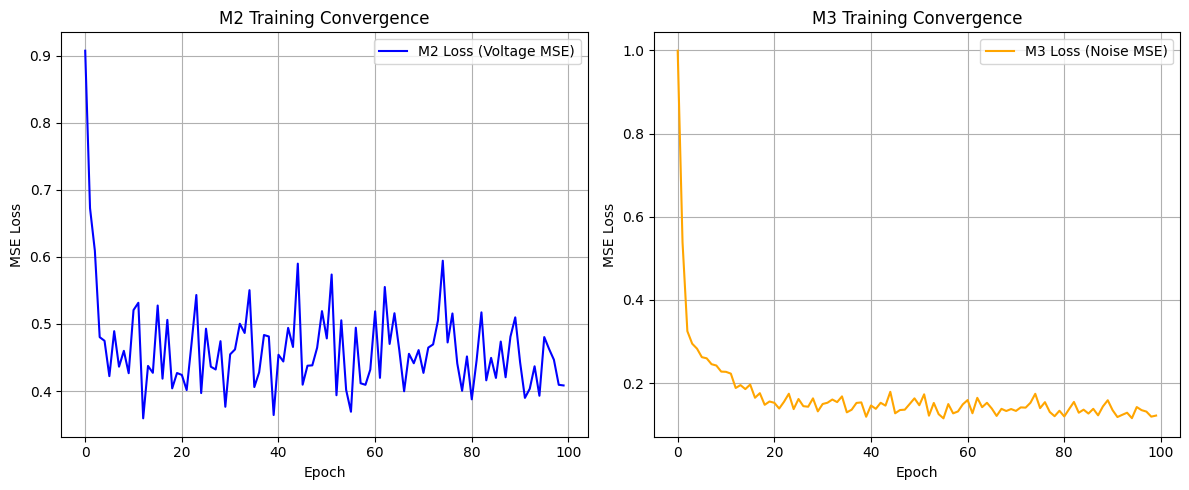

In [7]:
# 绘制训练曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history['m2'], label='M2 Loss (Voltage MSE)', color='blue')
plt.title('M2 Training Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history['m3'], label='M3 Loss (Noise MSE)', color='orange')
plt.title('M3 Training Convergence')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"{MODEL_SAVE_DIR}/final_loss_curve.png")
plt.show()